In [2]:
# XGBOOST from scratch
# dataset is from Kaggle
# dataset set will allow us to predict if someone wil stop using Telco's services or not 

In [3]:
import pandas as pd # for manipulation and ohe
import numpy as np # statistics
import xgboost as xgb 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix 


In [4]:
df = pd.read_csv('data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
# Dropping Customer ID which is not useful for our model
df.drop(['customerID'], axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Missing Data
# XGBoost knows how to handle missing data. We just have to identify it and make sure they are set to 0.
# What happens if we have actual zeros in data? XGBoost's writer said it does not interfare with XGBoost's performance.
# What sort of data in each column? 

In [8]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [9]:
# In theory we should check every column to verify if their types are correct, like this: 
df['PhoneService'].unique()

array(['No', 'Yes'], dtype=object)

In [10]:
# However we are not going to do that for every column. There is one specific colum that has a problem which is Total Charges. It includes numbers but its type is object.

df['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [11]:
# It looks like it has just numbers. But when we try to conver it into numeric we got an error:
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [12]:
# Error tells us there are blank spaces in this column. 

In [13]:
# Handling Missing Data 
# As I mentioned XGBoost has its own way to deal with missing data, we just have to set missing values to zero. HOWEVER, first we need to look at how many missing values are in the data. Because if there are too many of them, we have a bigger problem. In this case we cannot let XGBoost to handle this. 
# If there are not that much missing values then we can set them to zero.  

In [14]:
len(df.loc[df['TotalCharges']==' '])

11

In [15]:
# Since it is only 11 we can look at them.
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [16]:
# Tenure column is 0 in all rows. That means customers subscribed but they did not payed yet. 
# Since it is only 11 of them we are going to set Total Charges to zero. 


In [17]:
df['TotalCharges']= df['TotalCharges'].replace(r'^\s*$', 0, regex=True)


In [18]:
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [19]:
# Now we should change Total Charges' type to numeric. 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [20]:
# We are going to change every blank space to _
df.replace(' ', '_', regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


In [21]:
# Converting the predictor variable in a binary numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1


In [22]:
# Split data into response and explanatory
# Conventional notation: 
# X: Columns that we will use to make classifications (explanatory)
# y: The thing we want to predict (response)

In [23]:
X = df.drop('Churn', axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [24]:
y = df['Churn'].copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [25]:
# Formatting X (OHE)
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [26]:
# Not saving just looking
pd.get_dummies(X, columns=['PaymentMethod']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,29.85,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One_year,No,56.95,1889.50,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,...,No,No,One_year,No,42.30,1840.75,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0


In [27]:
# Note: One-Hot Encoding is not great for linear and logistic regression, but it works for trees. 

In [28]:
# Now we are saving the results
X_encoded = pd.get_dummies(X, columns=['gender',               
'SeniorCitizen',         
'Partner',            
'Dependents',                        
'PhoneService',      
'MultipleLines',      
'InternetService',   
'OnlineSecurity',  
'OnlineBackup', 
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies',
'Contract',
'PaperlessBilling',
'PaymentMethod' ])
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [29]:
# Building XGBoost model
# Looking for imbalance
sum(y)/len(y)

0.2653698707936959

In [30]:
# As far as we can understand 27% of the people left the company. 
# Splitting train and test.
X_train, X_test, y_train, y_test =train_test_split(X_encoded, y, stratify=y)

In [32]:
# Let's see if stratify worked.
sum(y_train)/len(y_train)

0.26519023282226006

In [33]:
sum(y_test)/len(y_test)

0.26519023282226006

In [ ]:
# We can see that it worked.

In [34]:
# Now the actual model. We are going to use early stopping to stop building the trees when they no longer improve the situtation. 
model_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=4)
model_xgb.fit(X_train,
y_train,
verbose=True,
early_stopping_rounds = 10,
eval_metric='aucpr',
eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.66456
[1]	validation_0-aucpr:0.66445
[2]	validation_0-aucpr:0.67899
[3]	validation_0-aucpr:0.68310
[4]	validation_0-aucpr:0.68014
[5]	validation_0-aucpr:0.68268
[6]	validation_0-aucpr:0.68000
[7]	validation_0-aucpr:0.67969
[8]	validation_0-aucpr:0.67993
[9]	validation_0-aucpr:0.68101
[10]	validation_0-aucpr:0.67897
[11]	validation_0-aucpr:0.67901
[12]	validation_0-aucpr:0.67959
[13]	validation_0-aucpr:0.67922


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=4,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
# Our best iteration is at [3]	validation_0-aucpr:0.68310

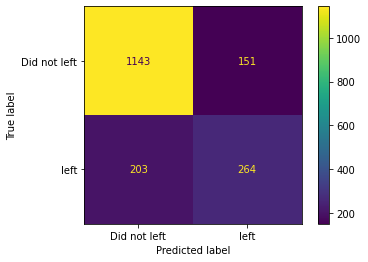

In [37]:
plot_confusion_matrix(
    model_xgb,
    X_test,
    y_test,
    values_format='d',
    display_labels=["Did not leave", "Left"]
)

In [ ]:
# We can see that XGBoost does not do well. There was an imbalance in the data.
# So we can optimize our model with a parameter due to imbalanceness. 

In [43]:
model_xgb = xgb.XGBClassifier(seed=4,
objective='binary:logistic',
gamma=0.25,
learn_rate=0.1,
max_depth=4,
reg_lambda= 10,
scale_pos_weight=3,
subsample=0.9,
colsample_bytree=0.5)

model_xgb.fit(X_train,
y_train,
verbose=True,
early_stopping_rounds=10,
eval_metric='aucpr',
eval_set=[(X_test, y_test)])

[20:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.52652
[1]	validation_0-aucpr:0.57968
[2]	validation_0-aucpr:0.58545
[3]	validation_0-aucpr:0.64886
[4]	validation_0-aucpr:0.64649
[5]	validation_0-aucpr:0.66510
[6]	validation_0-aucpr:0.66980
[7]	validation_0-aucpr:0.67067
[8]	validation_0-aucpr:0.67651
[9]	validation_0-aucpr:0.68152
[10]	validation_0-aucpr:0.67515
[11]	validation_0-aucpr:0.67971
[12]	validation_0-aucpr:0.68319
[13]	validation_0-aucpr:0.68395
[14]	validation_0-aucpr:0.68538
[15]	validation_0-aucpr:0.68591
[16]	validation_0-aucpr:0.68609
[17]	validation_0-aucpr:0.68825
[18]	validation_0-aucpr:0.68773
[19]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=4, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=4, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

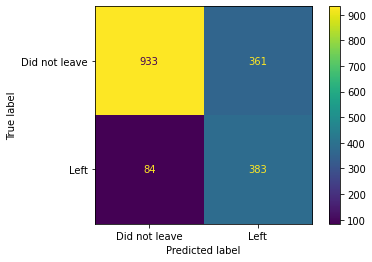

In [46]:
plot_confusion_matrix(model_xgb, X_test, y_test,
values_format= 'd', display_labels=['Did not leave', 'Left'])

In [ ]:
# XGBoost did a much better job at identifying people left the company. But there is an increase misclassification in people did not leave.

In [ ]:
# For my point of view it more important that the catch those who is about to leave the company so that we can give some kind of reward(coupons etc.). Because we do not want them to leave.  